# Cyclistic Bike-Share Analysis  
## Exploratory Analysis & Rider Behavior Insights

This notebook explores riding patterns and behavioural differences between casual riders and annual members to support data-driven business recommendations.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_PATH = Path("../data/raw")

files = sorted(DATA_PATH.glob("*.csv"))

df = pd.concat(
    [pd.read_csv(file) for file in files],
    ignore_index=True
)

# Convert timestamps
df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce")
df["ended_at"] = pd.to_datetime(df["ended_at"], errors="coerce")

# Create ride duration
df["ride_duration_minutes"] = (
    (df["ended_at"] - df["started_at"])
    .dt.total_seconds() / 60
)

# Clean invalid rides
df = df[
    (df["ride_duration_minutes"] > 0) &
    (df["ride_duration_minutes"] <= 1440)
].copy()

# Time features
df["ride_day_of_week"] = df["started_at"].dt.day_name()
df["ride_hour"] = df["started_at"].dt.hour
df["is_weekend"] = df["ride_day_of_week"].isin(["Saturday", "Sunday"])

df.shape

(5547380, 17)

In [2]:
df["member_casual"].value_counts(normalize=True).round(3)

member_casual
member    0.64
casual    0.36
Name: proportion, dtype: float64

## Rider Type Overview

- Annual members account for the majority of rides.
- Casual riders still represent a substantial portion of total usage.
- Behavioral differences between these two groups are critical for identifying
  opportunities to convert casual riders into annual members.

In [3]:
df.groupby("member_casual")["ride_duration_minutes"].describe()

,count,mean,std,min,25%,50%,75%,max
member_casual,,,,,,,,
casual,1994811.0,19.133336,38.979432,0.000767,6.295667,11.377383,21.0511,1439.975950
member,3552569.0,11.952484,20.355706,0.001300,5.029750,8.575667,14.4987,1439.901683


## Ride Duration by Rider Type

- Casual riders have significantly longer ride durations than annual members.
- The median casual ride is approximately 33% longer than the median member ride.
- Members exhibit shorter and more consistent ride durations, suggesting routine or commute-oriented usage.
- Casual riders display higher variability and longer upper-range durations, indicating recreational or exploratory behaviour.

This difference highlights an opportunity to convert frequent casual riders into annual members by targeting leisure-focused use cases.

In [4]:
df.groupby(["member_casual", "is_weekend"])["ride_duration_minutes"].median()

member_casual  is_weekend
casual         False         10.486800
               True          13.152733
member         False          8.418792
               True           9.141983
Name: ride_duration_minutes, dtype: float64

## Ride Duration by Rider Type and Day Type

- Casual riders take significantly longer rides on weekends compared to weekdays.
- This pattern suggests leisure-oriented usage, with weekends amplifying recreational behaviour.
- Annual members show relatively consistent ride durations across weekdays and weekends, indicating routine, utility-driven usage.

These patterns highlight an opportunity to design weekend-focused promotions and messaging to convert casual riders into annual members.

In [5]:
df.groupby(["member_casual", "ride_hour"])["ride_duration_minutes"].median().head(10)

member_casual  ride_hour
casual         0             8.626733
               1             8.652825
               2             8.495767
               3             8.153000
               4             6.894950
               5             7.567883
               6             7.170400
               7             7.811800
               8             8.559750
               9            10.091817
Name: ride_duration_minutes, dtype: float64

In [6]:
hourly_duration = (
    df
    .groupby(["member_casual", "ride_hour"])["ride_duration_minutes"]
    .median()
    .reset_index()
)

hourly_duration.head(12)

,member_casual,ride_hour,ride_duration_minutes
0,casual,0,8.626733
1,casual,1,8.652825
2,casual,2,8.495767
3,casual,3,8.153000
4,casual,4,6.894950
5,casual,5,7.567883
6,casual,6,7.170400
7,casual,7,7.811800
8,casual,8,8.559750
9,casual,9,10.091817


In [7]:
hourly_duration.tail(12)

,member_casual,ride_hour,ride_duration_minutes
36,member,12,7.947283
37,member,13,8.206283
38,member,14,8.625717
39,member,15,8.882925
40,member,16,9.252550
41,member,17,9.578450
42,member,18,9.142492
43,member,19,8.721608
44,member,20,8.654450
45,member,21,8.707650


In [8]:
hourly_pivot = hourly_duration.pivot(
    index="ride_hour",
    columns="member_casual",
    values="ride_duration_minutes"
)

hourly_pivot.head(12)

member_casual,casual,member
ride_hour,,
0,8.626733,7.665150
1,8.652825,7.309067
2,8.495767,7.235033
3,8.153000,7.635700
4,6.894950,7.047250
5,7.567883,7.051717
6,7.170400,7.625858
7,7.811800,8.269708
8,8.559750,8.370833


In [9]:
hourly_pivot.tail(12)

member_casual,casual,member
ride_hour,,
12,13.216242,7.947283
13,13.443750,8.206283
14,13.474517,8.625717
15,12.857917,8.882925
16,12.153633,9.252550
17,11.967533,9.578450
18,11.572992,9.142492
19,11.151100,8.721608
20,10.844233,8.654450


## Ride Duration by Hour of Day

- Casual riders exhibit significantly longer ride durations during late morning and early afternoon hours, peaking between 10:00 and 14:00.
- This pattern suggests leisure-driven usage, such as tourism and recreational rides.
- Annual members maintain relatively consistent ride durations throughout the day, with a modest increase during late afternoon commute hours.
- The contrast highlights distinct use cases: casual riders prioritize experience, while members prioritize efficiency and routine.

These insights suggest that targeted midday and weekend campaigns could be effective in converting casual riders into annual members.

In [10]:
df.groupby(["member_casual", "ride_hour"]).size().unstack().T

member_casual,casual,member
ride_hour,,
0,38847,32451
1,24892,19975
2,16634,12007
3,9183,7941
4,7271,8878
5,11408,34201
6,26523,100906
7,49547,199688
8,70313,256538


## Ride Volume by Hour of Day

- Annual members show strong ride volume peaks during traditional commute hours (7–9 AM and 16–18 PM), with the highest activity at 17:00.
- This pattern reflects routine, work-related usage and time efficiency.
- Casual riders display a gradual increase in ride volume throughout the day, peaking in the late afternoon.
- The absence of sharp morning peaks among casual riders indicates discretionary, leisure-oriented riding behavior.

Together with duration analysis, these patterns highlight a clear behavioral distinction between rider types and reinforce the opportunity to convert casual riders by targeting leisure-focused time windows.

## Day 3 Summary: Rider Behaviour Differences

- Casual riders consistently take longer trips than annual members, indicating leisure-oriented usage rather than point-to-point transportation.
- Annual members exhibit shorter ride durations and highly concentrated ride volumes during weekday commute hours (7–9 AM and 4–6 PM).
- Casual riders show increased activity during afternoons and weekends, with longer median ride durations during these periods.
- Ride volume analysis reveals that members use the service as a reliable mode of daily transportation, while casual riders use it more flexibly based on personal time and preference.
- The combination of higher duration and discretionary timing among casual riders suggests strong potential for conversion through weekend plans, day passes, or leisure-focused membership offerings.

In [11]:
weekend_volume = (
    df
    .groupby(["member_casual", "is_weekend"])
    .size()
    .reset_index(name="ride_count")
)

weekend_volume

,member_casual,is_weekend,ride_count
0,casual,False,1250781
1,casual,True,744030
2,member,False,2720338
3,member,True,832231


## Weekday vs Weekend Usage

This section compares ride volume between weekdays and weekends for casual riders and annual members.

In [12]:
weekend_pct = (
    weekend_volume
    .assign(
        pct=lambda x: x["ride_count"] /
        x.groupby("member_casual")["ride_count"].transform("sum")
    )
)

weekend_pct

,member_casual,is_weekend,ride_count,pct
0,casual,False,1250781,0.627017
1,casual,True,744030,0.372983
2,member,False,2720338,0.765738
3,member,True,832231,0.234262


### Insights

- Annual members complete the majority of their rides on weekdays, reflecting work and routine-driven usage.
- Casual riders have a much higher proportion of weekend rides, reinforcing their leisure-oriented behavior.
- Weekends represent a critical opportunity to engage casual riders when their usage intensity is highest.

In [14]:
df["ride_month"] = df["started_at"].dt.month

In [15]:
monthly_volume = (
    df
    .groupby(["member_casual", "ride_month"])
    .size()
    .reset_index(name="ride_count")
)

monthly_volume.head()

,member_casual,ride_month,ride_count
0,casual,1,24076
1,casual,2,27709
2,casual,3,85662
3,casual,4,108971
4,casual,5,182263


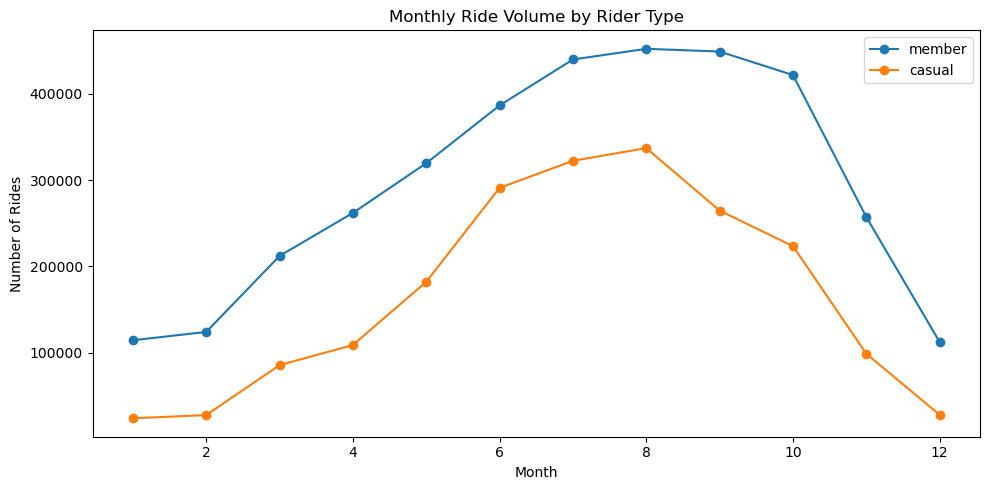

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for rider_type in ["member", "casual"]:
    subset = monthly_volume[monthly_volume["member_casual"] == rider_type]
    plt.plot(
        subset["ride_month"],
        subset["ride_count"],
        marker="o",
        label=rider_type
    )

plt.xlabel("Month")
plt.ylabel("Number of Rides")
plt.title("Monthly Ride Volume by Rider Type")
plt.legend()
plt.tight_layout()
plt.show()

## Seasonal Usage Patterns

- Both rider types show strong seasonality, with usage peaking in warmer months.
- Casual rider volume increases more sharply during peak seasons, suggesting higher sensitivity to weather and leisure conditions.
- Member usage is more stable across months, indicating consistent reliance on the service throughout the year.

Seasonal peaks present opportunities for targeted membership campaigns aimed at frequent casual riders.

## Day 4 Summary: Usage Patterns & Seasonality

- Annual members primarily use the service on weekdays, reinforcing its role as a routine transportation option.
- Casual riders show a significantly higher proportion of weekend usage, aligning with leisure-focused behavior.
- Ride volume for both groups peaks during warmer months, but the increase is much steeper for casual riders.
- Seasonal and weekend usage patterns indicate strong conversion potential among frequent casual riders during high-demand periods.